# 1. Data Collection  
The data collection isn't done through this notebook since it can be very lengthy in terms of time so it is done in a seperate script. The collection is long because it is achieved by scrapping webpages and making calls to an API. Both of these methods require some sort of timeout in between calls so that the server doesn't block our requests. Furthermore, the API used by the python code isn't supported by Anaconda. To collect the data set you must perform the following operations:
1. pip3 install -t ../dota2/requirements.txt
2. python3 ../dota2/src/api_wrapper.py  

The dataset will be saved in *../dota2/src/data/*  

## 1.1 Downloaded Files   
**Below are the dynamic/up to date files. Running the script above will gather recent data from the DOTA 2 servers:**  
[dota2api](http://dota2api.readthedocs.io/en/latest/index.html)
* match.json
* heroes.json
* items.json

[DOTABUFF](https://www.dotabuff.com/heroes/played)
* hero_monthly_stats.json
* player_stats.json

---

**Here are the static files that come with the repository:**  
[Liquipedia](https://liquipedia.net/dota2/Hero_Roles)
* hero_complexity.txt
* hero_role.txt

[dota2lists](http://dota2lists.blogspot.com/2014/06/dota-2-hero-abbreviations.html)
* hero_abbreviations.txt  

# 2 Data Discovery  
First and foremost, I am an experienced DOTA player which allows me to analyze the data easily and efficiently. In other words, where a novice would require professional help for analysis, I can achieve the same results on my own.   


The main data to use is the **match.json** file which is already well defined in a .json format. The **heroes.json** and **items.json** will compliment the former file through foreign keys. Finally, all other files will be used to enrich this information.  

It is not clear as of yet which information is relevant or irrelevant for the scope of this research so naturally the first step is to analyze each file individually.  

*Please note that the 3 original files I started with were **match.json**, **heroes.json**, and **items.json**. The other files were added as I saw fit throughout the lifecycle of this process.*

## 2.1 Analyzing match.json  

The **match.json** file is the main one to work with, so we start by inspecting this one.

In [1]:
import json
import pandas as pd

# load match data
with open('data/match.json') as f:
    raw_match_data = json.load(f)

# display table head
match_df = pd.DataFrame(raw_match_data).transpose()
match_df.head()

,barracks_status_dire,barracks_status_radiant,cluster,cluster_name,dire_captain,dire_logo,dire_name,dire_score,dire_team_complete,dire_team_id,...,radiant_captain,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,start_time,tower_status_dire,tower_status_radiant
3933443171,51,63,123,US East,NaN,NaN,NaN,33,NaN,NaN,...,NaN,NaN,NaN,44,NaN,NaN,True,1528134586,256,1846
3933443172,0,63,131,Europe West,NaN,NaN,NaN,34,NaN,NaN,...,NaN,NaN,NaN,49,NaN,NaN,True,1528134586,0,1983
3933443173,0,63,123,US East,NaN,NaN,NaN,40,NaN,NaN,...,NaN,NaN,NaN,68,NaN,NaN,True,1528134574,0,1844
3933443174,63,0,232,NaN,NaN,NaN,NaN,43,NaN,NaN,...,NaN,NaN,NaN,30,NaN,NaN,False,1528134585,1975,0
3933443175,0,63,155,Southeast Asia,NaN,NaN,NaN,31,NaN,NaN,...,NaN,NaN,NaN,54,NaN,NaN,True,1528134587,0,1974


Some columns are hidden due to their abbundance so we can simply print their headers.

In [97]:
match_df.columns

Index(['barracks_status_dire', 'barracks_status_radiant', 'cluster',
       'cluster_name', 'dire_captain', 'dire_logo', 'dire_name', 'dire_score',
       'dire_team_complete', 'dire_team_id', 'duration', 'engine',
       'first_blood_time', 'flags', 'game_mode', 'game_mode_name',
       'human_players', 'leagueid', 'lobby_name', 'lobby_type', 'match_id',
       'match_seq_num', 'negative_votes', 'picks_bans', 'players',
       'positive_votes', 'pre_game_duration', 'radiant_captain',
       'radiant_logo', 'radiant_name', 'radiant_score',
       'radiant_team_complete', 'radiant_team_id', 'radiant_win', 'start_time',
       'tower_status_dire', 'tower_status_radiant'],
      dtype='object')

We notice there are 2 columns with dictionaries: **picks_bans** and **players**. We can expand both of their fields to further investigate their contents.  

We also print out all the columns and eyeball their names to make sure we don't miss anything unusual.

### 2.1.1  Analyzing the player key
We first investigate the **players** key

In [2]:
index = match_df.index[0]
type(match_df.loc[index]['players'])

list

The player column is a list of players and therefore we will only display the values for the first item in the collection.

In [3]:
match_df.loc[index]['players'][0]

{'ability_upgrades': [{'ability': 5426, 'level': 1, 'time': 185},
  {'ability': 5427, 'level': 2, 'time': 363},
  {'ability': 5427, 'level': 3, 'time': 466},
  {'ability': 5428, 'level': 4, 'time': 624},
  {'ability': 5427, 'level': 5, 'time': 725},
  {'ability': 5429, 'level': 6, 'time': 832},
  {'ability': 5427, 'level': 7, 'time': 942},
  {'ability': 5428, 'level': 8, 'time': 997},
  {'ability': 5428, 'level': 9, 'time': 1154},
  {'ability': 5921, 'level': 10, 'time': 1219},
  {'ability': 5428, 'level': 11, 'time': 1385},
  {'ability': 5429, 'level': 12, 'time': 1430},
  {'ability': 5426, 'level': 13, 'time': 1523},
  {'ability': 5426, 'level': 14, 'time': 1538},
  {'ability': 6145, 'level': 15, 'time': 1623},
  {'ability': 5426, 'level': 16, 'time': 1693},
  {'ability': 5429, 'level': 17, 'time': 1824},
  {'ability': 6133, 'level': 18, 'time': 2100}],
 'account_id': 4294967295,
 'assists': 11,
 'backpack_0': 46,
 'backpack_1': 0,
 'backpack_2': 18,
 'deaths': 4,
 'denies': 10,
 'go

---
From the point of view of someone who has played hundreds of hours of DOTA, I can confirm that there are 2 types of information present in this column.  
1. A player's performance with a hero --> gold per minute, kills, deaths...
2. a player's choices throughout the game --> item selection, ability upgrades...   

This knowledge is usefull in order to determine what will need to be dropped later on.

### 2.1.1  Analyzing the pick_bans column

In [5]:
match_df.loc[index]['picks_bans'][0]

{'hero_id': 101, 'is_pick': False, 'order': 0, 'team': 0}

---
As expected, this column isn't too important for our purpose. DOTA offers different game modes, one from which, captains on both teams can choose and ban certain heroes from the draft in a sequential manner instead of a "free-for-all" way. This column is only useful if we investigate that particular game mode which is outside the scope of this research.

## 2.2 Analyzing the items.json
This data was recovered from the API since there are keys from the **match.json** files which points to this. From my hypothesis I do not think this will be very important as items are correlated with in-game decisions as opposed to drafting.

In [5]:
# load items.json
with open('data/items.json') as f:
    raw_item_data = json.load(f)
    
item_df = pd.DataFrame(raw_item_data)
item_df.head()

,items,status
0,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
1,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
2,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
3,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
4,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200


Once again we are confronted with a dictionary inside a column so we can investigate it further.

In [9]:
item_df.loc[0]['items']

{'cost': 2250,
 'id': 1,
 'localized_name': 'Blink Dagger',
 'name': 'item_blink',
 'recipe': 0,
 'secret_shop': 0,
 'side_shop': 1,
 'url_image': 'http://cdn.dota2.com/apps/dota2/images/items/blink_lg.png'}

---
There doesn't seem to be any interesting information in this data. So we can drop the **items.json** altogether.

## 2.3 Analyzing the heroes.json  
I have doubts to how pertinent this information can be since the hero name and id are both present in the **match.json**

In [6]:
# load heroes.json
with open('data/heroes.json') as f:
    raw_hero_data = json.load(f)
    
hero_df = pd.DataFrame(raw_hero_data)
hero_df.head()

,count,heroes,status
0,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
1,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
2,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
3,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
4,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200


It seems that dota2api likes nested information. We inspect the heroes column further.

In [10]:
hero_df.loc[0]['heroes']

{'id': 1,
 'localized_name': 'Anti-Mage',
 'name': 'npc_dota_hero_antimage',
 'url_full_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_full.png',
 'url_large_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_lg.png',
 'url_small_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_sb.png',
 'url_vertical_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_vert.jpg'}

---
The **id** and **localized_name** fields are interesting but the rest can be dropped. We keep this file in case we want to enrich it.

## 2.4 Analyzing game complexity  
There are many heroes and items available for play in a game and I am afraid that with a limited dataset, that the statistics/machine learning will perform poorly. So one interesting metric to look for is the drafting complexity.  

For the sake of curoisity, I have also decided to include the combinations of items in the calculations.  

**What we know:**  
1. 10 heroes are drafted per game and heroes cannot be drafted more than once.
2. 1 hero can hold up to 6 items and items can be purchased multiple times. (we are excluding the hero's stash for this)

In [96]:
import math
item_count = len(raw_item_data['items'])
heroes_count = len(raw_hero_data['heroes'])
heroes_per_game = 10

# hero combinations without repetition
numerator = math.factorial(heroes_count)
denominator = math.factorial(heroes_per_game) * math.factorial(heroes_count - heroes_per_game)
hero_combinations = numerator // denominator

# item combinations with repetition
# A hero can have 0 to 6 items so we calculate the permutations for every number of items
item_combinations = 0
for items_per_hero in range(7):
    numerator = math.factorial(item_count + items_per_hero - 1)
    denominator = math.factorial(item_count - 1) * math.factorial(items_per_hero)
    item_combinations += numerator // denominator

print("Hero Combinations: {}".format(hero_combinations))
print("Item Combinations per Hero: {}".format(item_combinations))

Hero Combinations: 74540394223878
Item Combinations per Hero: 607221379765


---
There is an astonishing **74540394223878** ways of drafting heroes with **607221379765** item combinations for **each** hero drafed! Multiplying these results will tell us how many different drafts and items builds are available.

In [97]:
# Theorycraft combinations
theory_craft_combination = hero_combinations * item_combinations
print('Theory Crafting: {:.2e}'.format(theory_craft_combination))

Theory Crafting: 4.53e+25


---
Finally we find that there are **4.53 * 10^25** theoretical hero setups. This number confirms my suspicions about the performance of a statistical tool which can help us evaluate this problem given that the research is conducted on only a finite set of data points in contrast to the monstrous number obtained. For this reason I have decided to classify the heroes into smaller categories.  

*Also note that heros can level up abilities in a sequential manner which would further increase the complexity stated above. I like to think that this information combined with the different ways of laning and playing would generate a number greater than the one representing the atoms of the universe.*

In [98]:
results = {
    'Combinations': {
        'Heroes': '{:.2e}'.format(hero_combinations),
        'Items': '{:.2e}'.format(item_combinations),
        'Theory Crafting': '{:.2e}'.format(theory_craft_combination)
    }    
}
pd.DataFrame(results)

,Combinations
Heroes,7.45e+13
Items,6.07e+11
Theory Crafting,4.53e+25


## 2.5 Analyzing hero_role.txt
With the numbers of the previous section, I have decided to find information about classifying heroes. In DOTA, every hero can fill multiple roles in a team so we can classify them respectively. Thankfully, the classification has been done by professional players and has been published on the [Liquipedia](https://liquipedia.net/dota2/Hero_Roles) website.  

First step is to look at the format of this information.

In [99]:
# load hero_role.txt
file = open('data/hero_role.txt', 'r')
raw_hero_role_data = ""

# for every line, add it to the empty string
for line in file:
    raw_hero_role_data += line
file.close()

# display only part of the content
print(raw_hero_role_data[:1000])

{| class="wikitable"
!colspan=8| ■■■ Carry
|-
|{{HeroIcon|am}}{{HeroIcon|arc}}{{HeroIcon|ck}}{{HeroIcon|gyro}}{{HeroIcon|medusa}}{{HeroIcon|morph}}{{HeroIcon|naga}}{{HeroIcon|pa}}<br>{{HeroIcon|sniper}}{{HeroIcon|
spectre}}{{HeroIcon|tb}}{{HeroIcon|tiny}}{{HeroIcon|troll}}
|-
!colspan=8| ■■ Carry
|-
|{{HeroIcon|alch}}{{HeroIcon|bb}}{{HeroIcon|dk}}{{HeroIcon|huskar}}{{HeroIcon|ls}}{{HeroIcon|lycan}}{{HeroIcon|mk}}{{HeroIcon|slardar}}<br>{{HeroIcon|sven}}{{HeroIcon|wk}}{{HeroIcon|clinkz}}{{HeroIcon|drow}}{{HeroIcon|ember}}{{HeroIcon|void}}{{HeroIcon|jugg}}{{HeroIcon|ld}}<br>{{HeroIcon|luna}}{{HeroIcon|meepo}}{{HeroIcon|pl}}{{HeroIcon|razor}}{{HeroIcon|riki}}{{HeroIcon|sf}}{{HeroIcon|slark}}{{HeroIcon|ta}}<br>{{HeroIcon|ursa}}{{HeroIcon|weaver}}{{HeroIcon|od}}{{HeroIcon|storm}}{{HeroIcon|pangolier}}
|-
!colspan=8| ■ Carry
|-
|{{HeroIcon|abaddon}}{{HeroIcon|brew}}{{HeroIcon|doom}}{{HeroIcon|kunkka}}{{HeroIcon|lc}}{{HeroIcon|ns}}{{HeroIcon|sb}}{{HeroIcon|bs}}<br>{{HeroIcon|brood}}{{HeroIcon

--- 
The data is unpleasant look at but we notice some level of formatting. According to the wikipedia article the number of '■' represents the difficulty of playing a particular hero for a given role. The name appearing right after the '■' symbol is the class. All items listed under the class are the heroes belonging to it.  

We can then find all the different roles and evaluate whether this classifying approach is feasible and worth the effort.

In [100]:
delimeter_start = "■■■ "
delimeter_end = "\n|-\n|"

# split data through delimeters
delimited_roles = raw_hero_role_data.split(delimeter_start)
roles_list = []

# append hero roles to list
for dr in delimited_roles:
    roles_list.append(dr.split(delimeter_end)[0])
roles_list = roles_list[1:]
print(roles_list)

['Carry', 'Nuker', 'Initiator', 'Disabler', 'Escape', 'Support', 'Pusher', 'Jungler', 'Durable']


---
It looks like there are only 9 roles available which seems correct when comparing to the website's page. This means that the string splitting was successfull. Additionally, 9 roles, where a hero can fulfill more than 1 of them, means that there are 512 role combinations. 
1. Assumption: there will be less than 512 combinations since no heroes can fill all the roles. Subsequently, no heroes can fill none of the roles. Ultimately, we hope that there would be less combinations than the total amount of heroes.
2. A team composition can be represented by an 9 bit integer or a 1 X 9 hotvector.
3. This technique will allow us to represent heroes by their numerical representations which will be useful later on with the machine learning.  

Points #2, and #3 are convincing enough to follow through this technique even if we eventually conclude that #1 won't hold true.

## 2.6 Analyzing hero complexity  
The complexity shares the same format as the **hero_role.text** file. 

In [114]:
# load hero_complexity.txt
file = open('data/hero_complexity.txt')
raw_hero_complexity_data = ""
for line in file:
    raw_hero_complexity_data += line
file.close()
print(raw_hero_complexity_data[500:1000])

y styles.

{| class="wikitable"
!colspan=8| ■■■ Complexity
|-
|{{HeroIcon|brewmaster}}{{HeroIcon|earth spirit}}{{HeroIcon|io}}{{HeroIcon|aw}}{{HeroIcon|ld}}{{HeroIcon|meepo}}{{HeroIcon|morph}}{{HeroIcon|chen}}<br>{{HeroIcon|invoker}}{{HeroIcon|oracle}}{{HeroIcon|rubick}}{{HeroIcon|storm}}{{HeroIcon|visage}}
|-
!colspan=8| ■■ Complexity
|-
|{{HeroIcon|beastmaster}}{{HeroIcon|clock}}{{HeroIcon|doom}}{{HeroIcon|earthshaker}}{{HeroIcon|et}}{{HeroIcon|kunkka}}{{HeroIcon|lifestealer}}{{HeroIcon|lycan}


---
After inspecting this file, I doubt that this data will be any usefull for the research. For instance, a hero can be very hard to play for most players but very easy for few players. For this reason, a hero's complexity will be reflected by a player's win ratio using this character. The win ratio heuristic is a more accurate representation of a hero's complexity than a general classification performed by humans.

## 2.7 Analyzing hero_abbreviations.txt
One key problem I have identified in the previous 2 text files from section 2.5 and 2.6 was that the hero names are non standard. Many of the names listed on the Liquipedia website uses a hero's acronym or nickname used by the DOTA community. Furthermore, a hero has both a name **and** a title which are used interchangeably by users. This information means that we need to standardize the hero names accross the dataset. For this reason, I have collected a dataset which maps all acronyms, titles, names, and nicknames to 1 standard format.

In [115]:
file = open("data/hero_abbreviations.txt", 'r')
sample = ""
for line in file:
    sample += line
file.close()
print(sample[:100])

Abaddon
Alch = Alchemist
AA = Ancient Apparition
AM = Anti-Mage
Arc = Arc Warden
Axe
Bane
Bat = Batr


---
1. Each new line is a new mapping
2. A mapping is shown by '='
3. No presence of '=' means that the name written is the hero's standard one
4. More than 1 mapping can be done per hero

## 2.8 Analyzing player_stats.json 
As mentioned in section 2.6, a player's stats with heroes should represent a more adequate heuristic for their performance. For this reason, I have scrapped [DOTABUFF](https://www.dotabuff.com/players) to obtain stats for players as the API wouldn't provide this functionality.

In [116]:
with open('data/player_stats.json') as f:
    raw_player_stats = json.load(f)

pd.DataFrame(raw_player_stats).transpose().head()

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Arc Warden,Axe,Bane,Batrider,Beastmaster,Bloodseeker,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
100008925,"{'kda': '1.6428572', 'win_ratio': '50.0', 'gam...","{'kda': '0.94', 'win_ratio': '25.0', 'games_pl...","{'kda': '2.9047618', 'win_ratio': '0.0', 'game...","{'kda': '1.9', 'win_ratio': '50.0', 'games_pla...",NaN,"{'kda': '2.402062', 'win_ratio': '56.0', 'game...","{'kda': '1.625', 'win_ratio': '28.57143', 'gam...","{'kda': '0.90909094', 'win_ratio': '33.333336'...","{'kda': '2.4166667', 'win_ratio': '50.0', 'gam...","{'kda': '1.5966387', 'win_ratio': '38.46154', ...",...,"{'kda': '0.9318182', 'win_ratio': '66.66667', ...","{'kda': '3.490196', 'win_ratio': '52.941177', ...","{'kda': '0.85365856', 'win_ratio': '0.0', 'gam...","{'kda': '1.6142857', 'win_ratio': '40.0', 'gam...","{'kda': '4.1363635', 'win_ratio': '80.0', 'gam...","{'kda': '2.255319', 'win_ratio': '37.5', 'game...",NaN,"{'kda': '1.6140351', 'win_ratio': '45.454548',...","{'kda': '7.4', 'win_ratio': '87.5', 'games_pla...","{'kda': '3.1243522', 'win_ratio': '40.0', 'gam..."
100017039,"{'kda': '2.1860466', 'win_ratio': '66.66667', ...","{'kda': '1.462963', 'win_ratio': '28.57143', '...","{'kda': '2.7595909', 'win_ratio': '53.19149', ...","{'kda': '1.7783641', 'win_ratio': '40.816326',...","{'kda': '1.3333334', 'win_ratio': '33.333336',...","{'kda': '1.9156626', 'win_ratio': '52.63158', ...","{'kda': '1.8333334', 'win_ratio': '100.0', 'ga...","{'kda': '2.3055556', 'win_ratio': '50.0', 'gam...","{'kda': '2.8', 'win_ratio': '100.0', 'games_pl...","{'kda': '2.0159745', 'win_ratio': '51.6129', '...",...,"{'kda': '1.7219917', 'win_ratio': '45.454548',...","{'kda': '2.4564102', 'win_ratio': '35.0', 'gam...","{'kda': '2.8095238', 'win_ratio': '50.0', 'gam...","{'kda': '2.170886', 'win_ratio': '38.88889', '...","{'kda': '3.1704545', 'win_ratio': '47.368423',...","{'kda': '2.2845118', 'win_ratio': '45.714287',...","{'kda': '2.0424528', 'win_ratio': '56.0', 'gam...","{'kda': '1.965642', 'win_ratio': '61.818184', ...","{'kda': '2.2537313', 'win_ratio': '50.0', 'gam...","{'kda': '4.2988505', 'win_ratio': '66.37931', ..."
100048207,"{'kda': '2.8888888', 'win_ratio': '100.0', 'ga...","{'kda': '4.0833335', 'win_ratio': '50.0', 'gam...","{'kda': '8.5', 'win_ratio': '100.0', 'games_pl...","{'kda': '4.7325583', 'win_ratio': '59.090908',...",NaN,"{'kda': '3.0930233', 'win_ratio': '16.666668',...","{'kda': '3.878788', 'win_ratio': '50.0', 'game...","{'kda': '2.3333333', 'win_ratio': '100.0', 'ga...",NaN,"{'kda': '4.629032', 'win_ratio': '72.72727', '...",...,"{'kda': '2.4545455', 'win_ratio': '50.0', 'gam...","{'kda': '4.967742', 'win_ratio': '40.0', 'game...",NaN,NaN,"{'kda': '10.75', 'win_ratio': '100.0', 'games_...","{'kda': '6.5194173', 'win_ratio': '59.615387',...","{'kda': '3.2916667', 'win_ratio': '75.0', 'gam...","{'kda': '3.0769231', 'win_ratio': '100.0', 'ga...","{'kda': '9.846154', 'win_ratio': '60.000004', ...","{'kda': '6.354839', 'win_ratio': '83.33333', '..."
100052152,"{'kda': '2.7674417', 'win_ratio': '53.846157',...","{'kda': '2.2682292', 'win_ratio': '32.0', 'gam...","{'kda': '4.0699706', 'win_ratio': '49.056606',...","{'kda': '3.166205', 'win_ratio': '58.73016', '...","{'kda': '1.5', 'win_ratio': '0.0', 'games_play...","{'kda': '2.7202382', 'win_ratio': '45.0', 'gam...",NaN,"{'kda': '2.4444444', 'win_ratio': '50.0', 'gam...","{'kda': '2.3157895', 'win_ratio': '50.0', 'gam...","{'kda': '4.1893334', 'win_ratio': '68.316826',...",...,"{'kda': '2.912676', 'win_ratio': '50.0', 'game...","{'kda': '2.9789474', 'win_ratio': '25.0', 'gam...","{'kda': '1.1818181', 'win_ratio': '33.333336',...","{'kda': '3.4347825', 'win_ratio': '36.842106',...","{'kda': '5.4375', 'win_ratio': '63.636364', 'g...","{'kda': '2.703504', 'win_ratio': '24.528303', ...","{'kda': '1.9655173', 'win_ratio': '27.272728',...","{'kda': '3.3529413', 'win_ratio': '60.975613',...","{'kda': '4.0170455', 'wi

All the stats are well formatted in the table above with **KDA** (kill, death, assists), **WIN RATIO**, and **GAMES PLAYED**. There are 2 elements to note:
1. The stats are per hero
2. Some players enabled a setting which prevents DOTABUFF from collecting a user's information. Those user's information are "NULL" in our dataset.

Because of point #2, our data will be missing information.

## 2.9 Analyzing hero_monthly_stats.json
Finally, the complete the set, we need to replace a player's stats missing values with something. I have decided to replace them with the average of all players which can be found on DOTABUFF.

In [117]:
with open('data/hero_monthly_stats.json') as f:
    raw_player_stats = json.load(f)

pd.DataFrame(raw_player_stats).transpose().head()

,games_played,kda,pick_rate,win_ratio
Abaddon,791546,2.7654,3.6965,53.1139
Alchemist,960535,2.1499,4.4857,47.1541
Ancient Apparition,1427552,2.9394,6.6667,52.3227
Anti-Mage,2956043,2.4468,13.8049,49.3661
Arc Warden,401207,2.6083,1.8736,47.2212


---
Not much needs to be said about the above information, it was structured by me when I scrapped the information and looks pretty staight forward.

# 3. Hero DataFrame  
In this section, we want to enrich the hero.json file by adding a hero's role and stats for the month.

## 3.1 Cleaning hero_role.txt
### 3.1.1 New delimeters
The first step was to create a new set of delimeters seperate from the '{{}}' which will be easier to use for regex later on.

In [160]:
# load hero_role.txt
file = open('data/hero_role.txt', 'r')
raw_hero_role_data = ""

# for every line, add it to the empty string
for line in file:
    raw_hero_role_data += line
file.close()

updated_hero_role_data = ""

# replace all unecessary strings
updated_hero_role_data = raw_hero_role_data.replace("{{HeroIcon|", "|")
updated_hero_role_data = updated_hero_role_data.replace("}}", "| ")
updated_hero_role_data = updated_hero_role_data.replace("|-\n", "")
updated_hero_role_data = updated_hero_role_data.replace("<br>", "")

# print sample of new format
print(updated_hero_role_data[:500])

{| class="wikitable"
!colspan=8| ■■■ Carry
||am| |arc| |ck| |gyro| |medusa| |morph| |naga| |pa| |sniper| |spectre| |tb| |tiny| |troll| 
!colspan=8| ■■ Carry
||alch| |bb| |dk| |huskar| |ls| |lycan| |mk| |slardar| |sven| |wk| |clinkz| |drow| |ember| |void| |jugg| |ld| |luna| |meepo| |pl| |razor| |riki| |sf| |slark| |ta| |ursa| |weaver| |od| |storm| |pangolier| 
!colspan=8| ■ Carry
||abaddon| |brew| |doom| |kunkka| |lc| |ns| |sb| |bs| |brood| |mirana| |viper| |dp| |invoker| |leshrac| |lina| |np| |n


---
### 3.1.2 Regex
The next step is to regex all the hero names.

In [161]:
import re

# regex to match hero names
hero_regex = re.compile("\|.*\|")

# list of matches
hero_regex_matches = re.findall(hero_regex, updated_hero_role_data)
for i in range(len(hero_regex_matches)):
    hero_regex_matches[i] = hero_regex_matches[i].replace("|", ", ")

# display list content
print(hero_regex_matches)

[', , am,  , arc,  , ck,  , gyro,  , medusa,  , morph,  , naga,  , pa,  , sniper,  , spectre,  , tb,  , tiny,  , troll, ', ', , alch,  , bb,  , dk,  , huskar,  , ls,  , lycan,  , mk,  , slardar,  , sven,  , wk,  , clinkz,  , drow,  , ember,  , void,  , jugg,  , ld,  , luna,  , meepo,  , pl,  , razor,  , riki,  , sf,  , slark,  , ta,  , ursa,  , weaver,  , od,  , storm,  , pangolier, ', ', , abaddon,  , brew,  , doom,  , kunkka,  , lc,  , ns,  , sb,  , bs,  , brood,  , mirana,  , viper,  , dp,  , invoker,  , leshrac,  , lina,  , np,  , necro,  , qop,  , silencer,  , tinker,  , wr, ', ', , phoenix,  , timber,  , sf,  , invoker,  , lesh,  , lina,  , lion,  , oracle,  , qop,  , skywrath,  , techies,  , tinker,  , zeus, ', ', , earth spirit,  , sk,  , tiny,  , luna,  , meepo,  , nyx,  , cm,  , jakiro,  , kotl,  , lich,  , necro,  , ogre,  , od,  , puck,  , pugna,  , shaman,  , storm,  , visage,  , wd,  , pangolier,  , dark willow, ', ', , alch,  , beastmaster,  , brew,  , bb,  , centaur,  ,

### 3.1.3 Creating the mapping dictionary
In this step we use the **hero_abbreviations.txt** file to create a dictionary which will map all above keys to their standard values.

In [162]:
# load data
file = open("data/hero_abbreviations.txt", 'r')
hero_abbr = {}
for line in file:
    txt = line.lower()
    # split with '='. Left hand side is abbreviation
    key = txt.split(' =')[0]
    try:
        # right hand side is hero full name
        value = txt.split('= ')[1]
        value = value.replace("\n", "")        
    except IndexError:
        key = key.replace("\n", "")
        value = key        
    hero_abbr[key] = value
    hero_abbr[value] = value
file.close()
print(hero_abbr)

{'abaddon': 'abaddon', 'alch': 'alchemist', 'alchemist': 'alchemist', 'aa': 'ancient apparition', 'ancient apparition': 'ancient apparition', 'am': 'anti-mage', 'anti-mage': 'anti-mage', 'arc': 'arc warden', 'arc warden': 'arc warden', 'axe': 'axe', 'bane': 'bane', 'bat': 'batrider', 'batrider': 'batrider', 'bm': 'beastmaster', 'beastmaster': 'beastmaster', 'beast': 'beastmaster', 'bs': 'bloodseeker', 'bloodseeker': 'bloodseeker', 'bh': 'bounty hunter', 'bounty hunter': 'bounty hunter', 'brew': 'brewmaster', 'brewmaster': 'brewmaster', 'bb': 'bristleback', 'bristleback': 'bristleback', 'brood': 'broodmother', 'broodmother': 'broodmother', 'centaur': 'centaur warrunner', 'centaur warrunner': 'centaur warrunner', 'cent': 'centaur warrunner', 'ck': 'chaos knight', 'chaos knight': 'chaos knight', 'chen': 'chen', 'clinkz': 'clinkz', 'clock': 'clockwerk', 'clockwerk': 'clockwerk', 'cm': 'crystal maiden', 'crystal maiden': 'crystal maiden', 'ds': 'dark seer', 'dark seer': 'dark seer', 'dazzle

### 3.1.4 Standardizing hero names 
The above output shows us the content of the dictionary. We can now use this to map hero abbreviations to their full names so that they match the rest of the dataset.

In [163]:
cleaned_hero_names = []
for i in range(len(hero_regex_matches)):
    line = hero_regex_matches[i].split(", ")        
    tmp_list = []
    for j in range(len(line)):
        if line[j] == ' ' or line[j] == '':
            pass
        else:
            tmp_list.append(hero_abbr[line[j]])
    cleaned_hero_names.append(tmp_list)
print(cleaned_hero_names)

[['anti-mage', 'arc warden', 'chaos knight', 'gyrocopter', 'medusa', 'morphling', 'naga siren', 'phantom assassin', 'sniper', 'spectre', 'terrorblade', 'tiny', 'troll warlord'], ['alchemist', 'bristleback', 'dragon knight', 'huskar', 'lifestealer', 'lycan', 'monkey king', 'slardar', 'sven', 'wraith king', 'clinkz', 'drow ranger', 'ember spirit', 'faceless void', 'juggernaut', 'lone druid', 'luna', 'meepo', 'phantom lancer', 'razor', 'riki', 'shadow fiend', 'slark', 'templar assassin', 'ursa', 'weaver', 'outworld devourer', 'storm spirit', 'pangolier'], ['abaddon', 'brewmaster', 'doom', 'kunkka', 'legion commander', 'night stalker', 'spirit breaker', 'bloodseeker', 'broodmother', 'mirana', 'viper', 'death prophet', 'invoker', 'leshrac', 'lina', "nature's prophet", 'necrophos', 'queen of pain', 'silencer', 'tinker', 'windranger'], ['phoenix', 'timbersaw', 'shadow fiend', 'invoker', 'leshrac', 'lina', 'lion', 'oracle', 'queen of pain', 'skywrath mage', 'techies', 'tinker', 'zeus'], ['eart

---
The above code generates a list of all the heroes by their roles in the same order in which they appear from the wikipedia dataset. --> [carry:[hero_1, hero_2], support:[hero_n], ...]. There are no errors during runtime which tells us that every hero has been mapped appropriately.

### 3.1.5 Grouping heroes by roles
The final step is the create a dictionary which will map roles to a list of heroes which can then easily be used by pandas to create a dataframe. From the dataset we notice a sequence --> <hard, semi, weak> <role>. So every 3rd element in a list has the same magnitude (hard, semi, weak). After 3 elements, the role is updated.

In [164]:
cleaned_roles_dict = {}
role_index = -1
for i in range(len(cleaned_hero_names)):    
    role_strength = i % 3        
    if role_strength == 0:
        role_index += 1    
    hard_role = roles_list[role_index].lower()
    try:
        cleaned_roles_dict[hard_role] += cleaned_hero_names[i]
    except KeyError:
        cleaned_roles_dict[hard_role] = cleaned_hero_names[i] 

# print only the first key: value from the dictionary
for key in cleaned_roles_dict:
    print(cleaned_roles_dict[key])
    break

['anti-mage', 'arc warden', 'chaos knight', 'gyrocopter', 'medusa', 'morphling', 'naga siren', 'phantom assassin', 'sniper', 'spectre', 'terrorblade', 'tiny', 'troll warlord', 'alchemist', 'bristleback', 'dragon knight', 'huskar', 'lifestealer', 'lycan', 'monkey king', 'slardar', 'sven', 'wraith king', 'clinkz', 'drow ranger', 'ember spirit', 'faceless void', 'juggernaut', 'lone druid', 'luna', 'meepo', 'phantom lancer', 'razor', 'riki', 'shadow fiend', 'slark', 'templar assassin', 'ursa', 'weaver', 'outworld devourer', 'storm spirit', 'pangolier', 'abaddon', 'brewmaster', 'doom', 'kunkka', 'legion commander', 'night stalker', 'spirit breaker', 'bloodseeker', 'broodmother', 'mirana', 'viper', 'death prophet', 'invoker', 'leshrac', 'lina', "nature's prophet", 'necrophos', 'queen of pain', 'silencer', 'tinker', 'windranger']


--- 
The above output represents all the carry heroes. After a quick glance and comparison with the dataset, the dictionary seems to have been created appropriately and therefore the cleaning has been successful.

### 3.1.6 Representing roles by integers  
The machine learning model will need integers instead of strings. Also notice that certain heroes fit more than 1 role because they can be played differently. For this reason every hero is represented by an 8 bit number where every bit represents a role.

In [165]:
role_bits = {
    'role': {}
}

index = 0
for role in cleaned_roles_dict:
    role_bits['role'][role] = index
    index += 1
role_bits_df = pd.DataFrame(role_bits)     
role_bits_df.transpose().head()

,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,support
role,0,3,8,4,2,7,1,6,5


---
We then save the roles ad their associated bits to a .json file for use later if necessary.

In [166]:
with open('data/role_bits.json', 'w') as outfile:
    json.dump(role_bits, outfile)

## 3.2 Structuring the hero roles  
### 3.2.1 Assigning hero roles
In order to maximize informaiton, I have decided to represent every hero's role by a 1 hot vector and an 8 bit integer.  

The math is simple, a hero's score is calculated by the summation of the character's role bit indices to the power of 2. This will give us the integer representation of the 1 hot vector.

In [167]:
hero_roles_dict = {}
for key in cleaned_roles_dict:
    for hero in cleaned_roles_dict[key]:
        if hero in hero_roles_dict:
            hero_roles_dict[hero]['score'] += 2**role_bits['role'][key]            
        else:
            hero_roles_dict[hero] = {
                'score': 2**role_bits['role'][key],
                'carry': 0, 
                'disabler': 0, 
                'escape': 0, 
                'initiator': 0,
                'jungler': 0, 
                'nuker': 0, 
                'pusher': 0, 
                'support': 0,
                'durable': 0
            }
        hero_roles_dict[hero][key] = 1
hero_scores_df = pd.DataFrame(hero_roles_dict).transpose()
hero_scores_df = hero_scores_df.reset_index()
hero_scores_df = hero_scores_df.rename({'index':'hero_name'}, axis='columns')
hero_scores_df.head()

,hero_name,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,1,0,1,0,0,0,0,0,289,1
1,alchemist,1,1,1,0,1,0,1,0,303,1
2,ancient apparition,0,1,0,0,0,0,1,0,42,1
3,anti-mage,1,0,0,1,0,0,1,0,19,0
4,arc warden,1,0,0,1,0,0,1,0,19,0


### 3.2.2 Creating hero id table
Here we can use the information from the **hero.json** dataset to create a table with hero names and unique id.

In [168]:
with open('data/heroes.json') as f:
    raw_hero_data = json.load(f)
    
hero_roles_dict = {
    'hero': {}
}

hero_list = raw_hero_data['heroes']

for dictionary in hero_list:
    dictionary['localized_name'] = dictionary['localized_name'].lower()            
    hero_name = dictionary['localized_name']    

hero_df = pd.DataFrame(hero_list) 
hero_df = hero_df.reset_index()

# rename columns to fit rest of dataset
hero_df = hero_df.rename({'localized_name':'hero_name','id': 'hero_id'}, axis='columns')

# columns to drop
drop_columns = [
    'name',
    'url_full_portrait',
    'url_large_portrait',
    'url_small_portrait',
    'url_vertical_portrait',
    'index'
]
hero_df = hero_df.drop(columns=drop_columns)
hero_df.head()

,hero_id,hero_name
0,1,anti-mage
1,2,axe
2,3,bane
3,4,bloodseeker
4,5,crystal maiden


## 3.3 Enriching Hero DataFrame
### 3.3.1 Merging roles
Finally we can merge this table right above with the hero roles based on their names.

In [169]:
hero_df = pd.merge(hero_df, hero_scores_df, on='hero_name')
hero_df.head()

,hero_id,hero_name,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
0,1,anti-mage,1,0,0,1,0,0,1,0,19,0
1,2,axe,0,1,1,0,1,1,0,0,396,0
2,3,bane,0,1,1,0,0,0,1,0,298,1
3,4,bloodseeker,1,1,0,0,1,1,1,0,143,0
4,5,crystal maiden,0,1,0,0,0,1,1,0,170,1


### 3.3.2 Community Monthly stats per heroes  
Here we load the hero monthly stats and rename the columns to be more specific in order to avoid merging problems later on.

In [173]:
# load hero_monthly_stats
with open('data/hero_monthly_stats.json') as f:
    hero_monthly_stats = json.load(f)
    
hero_monthly_stats_df = pd.DataFrame(hero_monthly_stats).transpose()
hero_monthly_stats_df = hero_monthly_stats_df.reset_index()

# rename columns
hero_monthly_stats_df = hero_monthly_stats_df.rename({
    'index':'hero_name', 
    'games_played':'hero_games_played',
    'kda':'hero_kda',
    'win_ratio':'hero_win_ratio'
    }, axis='columns')
hero_monthly_stats_df['hero_name'] = hero_monthly_stats_df['hero_name'].str.lower()
hero_monthly_stats_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio
0,abaddon,791546,2.7654,3.6965,53.1139
1,alchemist,960535,2.1499,4.4857,47.1541
2,ancient apparition,1427552,2.9394,6.6667,52.3227
3,anti-mage,2956043,2.4468,13.8049,49.3661
4,arc warden,401207,2.6083,1.8736,47.2212


### 3.3.3 Merging Monthly stats and Roles

In [171]:
hero_df = pd.merge(hero_monthly_stats_df, hero_df, on='hero_name')
hero_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio,hero_id,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,791546,2.7654,3.6965,53.1139,102,1,0,1,0,0,0,0,0,289,1
1,alchemist,960535,2.1499,4.4857,47.1541,73,1,1,1,0,1,0,1,0,303,1
2,ancient apparition,1427552,2.9394,6.6667,52.3227,68,0,1,0,0,0,0,1,0,42,1
3,anti-mage,2956043,2.4468,13.8049,49.3661,1,1,0,0,1,0,0,1,0,19,0
4,arc warden,401207,2.6083,1.8736,47.2212,113,1,0,0,1,0,0,1,0,19,0


In [174]:
with open('data/enriched_heroes.json', 'w') as outfile:
    outfile.write(hero_df.to_json(orient='records', lines=True))

---
The merge was successfull! All heroes are now identified by their roles and unique identifiers. We can save this file for use later.

## 4. Match DataFrame
### 3.2.1 Match meta data
We first show the match_df header to refresh our memory on this dataset. 

In [28]:
match_df = pd.DataFrame(raw_match_data)
match_df = match_df.transpose()
match_df.head()

,barracks_status_dire,barracks_status_radiant,cluster,cluster_name,dire_captain,dire_logo,dire_name,dire_score,dire_team_complete,dire_team_id,...,radiant_captain,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,start_time,tower_status_dire,tower_status_radiant
3933443171,51,63,123,US East,NaN,NaN,NaN,33,NaN,NaN,...,NaN,NaN,NaN,44,NaN,NaN,True,1528134586,256,1846
3933443172,0,63,131,Europe West,NaN,NaN,NaN,34,NaN,NaN,...,NaN,NaN,NaN,49,NaN,NaN,True,1528134586,0,1983
3933443173,0,63,123,US East,NaN,NaN,NaN,40,NaN,NaN,...,NaN,NaN,NaN,68,NaN,NaN,True,1528134574,0,1844
3933443174,63,0,232,NaN,NaN,NaN,NaN,43,NaN,NaN,...,NaN,NaN,NaN,30,NaN,NaN,False,1528134585,1975,0
3933443175,0,63,155,Southeast Asia,NaN,NaN,NaN,31,NaN,NaN,...,NaN,NaN,NaN,54,NaN,NaN,True,1528134587,0,1974


In [29]:
match_df.columns

Index(['barracks_status_dire', 'barracks_status_radiant', 'cluster',
       'cluster_name', 'dire_captain', 'dire_logo', 'dire_name', 'dire_score',
       'dire_team_complete', 'dire_team_id', 'duration', 'engine',
       'first_blood_time', 'flags', 'game_mode', 'game_mode_name',
       'human_players', 'leagueid', 'lobby_name', 'lobby_type', 'match_id',
       'match_seq_num', 'negative_votes', 'picks_bans', 'players',
       'positive_votes', 'pre_game_duration', 'radiant_captain',
       'radiant_logo', 'radiant_name', 'radiant_score',
       'radiant_team_complete', 'radiant_team_id', 'radiant_win', 'start_time',
       'tower_status_dire', 'tower_status_radiant'],
      dtype='object')

### 3.2.2 Droping columns
From the list above we notice that quite a few columns are not necessary for further analysis

In [30]:
drop_list = [
    'dire_captain', 
    'cluster', 
    'cluster_name', 
    'engine', 
    'match_seq_num', 
    'negative_votes', 
    'positive_votes',
    'lobby_type',
    'start_time',
    'radiant_captain',
    'pre_game_duration',    
    'lobby_name',
    'leagueid',
    'flags',
    'game_mode_name',
    'game_mode',
    'first_blood_time',
    'match_id',
    'players',
    'picks_bans'
]
match_df = match_df.drop(columns = drop_list)
match_df = match_df.reset_index()
match_df = match_df.rename({'index':'match_id'}, axis='columns')
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_logo,dire_name,dire_score,dire_team_complete,dire_team_id,duration,human_players,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,tower_status_dire,tower_status_radiant
0,3933443171,51,63,NaN,NaN,33,NaN,NaN,2181,10,NaN,NaN,44,NaN,NaN,True,256,1846
1,3933443172,0,63,NaN,NaN,34,NaN,NaN,2471,10,NaN,NaN,49,NaN,NaN,True,0,1983
2,3933443173,0,63,NaN,NaN,40,NaN,NaN,2954,10,NaN,NaN,68,NaN,NaN,True,0,1844
3,3933443174,63,0,NaN,NaN,43,NaN,NaN,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
4,3933443175,0,63,NaN,NaN,31,NaN,NaN,2469,10,NaN,NaN,54,NaN,NaN,True,0,1974


### 3.2.3 Removing bad data  
1. From the information presented above, the only data we want to remove are games in which there are less than 10 players. Since DOTA is a 5v5 game then have less players will skew the results.  
2. Remove data where radiant_win is undefined

In [31]:
match_df = match_df.dropna(subset = ['radiant_win'])
match_df = match_df[match_df['human_players'] == 10]
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_logo,dire_name,dire_score,dire_team_complete,dire_team_id,duration,human_players,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,tower_status_dire,tower_status_radiant
0,3933443171,51,63,NaN,NaN,33,NaN,NaN,2181,10,NaN,NaN,44,NaN,NaN,True,256,1846
1,3933443172,0,63,NaN,NaN,34,NaN,NaN,2471,10,NaN,NaN,49,NaN,NaN,True,0,1983
2,3933443173,0,63,NaN,NaN,40,NaN,NaN,2954,10,NaN,NaN,68,NaN,NaN,True,0,1844
3,3933443174,63,0,NaN,NaN,43,NaN,NaN,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
4,3933443175,0,63,NaN,NaN,31,NaN,NaN,2469,10,NaN,NaN,54,NaN,NaN,True,0,1974


# 5. Player DataFrame
## 4.1 Creating player dataframe  
The player data wasn't kept in the match dataframe although it is useful to us. So we can create a new player dataframe with one of the columns pointing to the match id in which this player participated.

In [32]:
with open('data/match.json') as f:
    raw_match_data = json.load(f)

player_list = []

for keys in raw_match_data:
    for i in range(len(raw_match_data[keys]['players'])):        
        try:
            del raw_match_data[keys]['players'][i]['ability_upgrades']                
        except KeyError:
            pass 
        raw_match_data[keys]['players'][i]['match_id'] = keys        
        player_list.append(raw_match_data[keys]['players'][i])
    
players_df = pd.DataFrame(player_list)
players_df.head()

,account_id,additional_units,assists,backpack_0,backpack_1,backpack_2,deaths,denies,gold,gold_per_min,...,leaver_status_description,leaver_status_name,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,tower_damage,xp_per_min
0,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,0,0,0,0,0,0
1,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,1,0,0,0,0,0
2,4.294967e+09,NaN,0,0,0,0,0,0,0,30607,...,"player AFK, abandon",AFK,0,3933453572,2,0,0,0,0,0
3,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,3,0,0,0,0,0
4,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,4,0,0,0,0,0


In [33]:
players_df.columns

Index(['account_id', 'additional_units', 'assists', 'backpack_0', 'backpack_1',
       'backpack_2', 'deaths', 'denies', 'gold', 'gold_per_min', 'gold_spent',
       'hero_damage', 'hero_healing', 'hero_id', 'hero_name', 'item_0',
       'item_0_name', 'item_1', 'item_1_name', 'item_2', 'item_2_name',
       'item_3', 'item_3_name', 'item_4', 'item_4_name', 'item_5',
       'item_5_name', 'kills', 'last_hits', 'leaver_status',
       'leaver_status_description', 'leaver_status_name', 'level', 'match_id',
       'player_slot', 'scaled_hero_damage', 'scaled_hero_healing',
       'scaled_tower_damage', 'tower_damage', 'xp_per_min'],
      dtype='object')

### 4.1.2 Removing unecessary columns

In [34]:
drop_columns = [
    'leaver_status_description',
    'leaver_status_name',    
    'item_0_name',
    'item_1_name',
    'item_2_name',
    'item_3_name',
    'item_4_name',
    'item_5_name',
    'item_0',
    'item_1',
    'item_2',
    'item_3',
    'item_4',
    'item_5',
    'backpack_0',
    'backpack_1',
    'backpack_2',
    'hero_damage',
    'hero_healing',
    'tower_damage',
    'additional_units',
    'leaver_status'
]

players_df = players_df.drop(columns = drop_columns)
players_df.columns

Index(['account_id', 'assists', 'deaths', 'denies', 'gold', 'gold_per_min',
       'gold_spent', 'hero_id', 'hero_name', 'kills', 'last_hits', 'level',
       'match_id', 'player_slot', 'scaled_hero_damage', 'scaled_hero_healing',
       'scaled_tower_damage', 'xp_per_min'],
      dtype='object')

### 4.2.3 Dropping/Formatting bad data
If an account ID or a hero name is unadentified then we drop the data entirely. Additionally, we change the hero names to lower case and change the account_id column from float to integer.

In [35]:
players_df = players_df.dropna(subset = ['account_id'])
players_df = players_df.dropna(subset = ['hero_name'])
players_df['account_id'] = players_df['account_id'].astype(int)
players_df['hero_name'] = players_df['hero_name'].str.lower()
players_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,last_hits,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,xp_per_min
10,390652758,6,10,1,596,342,11055,59,huskar,10,81,19,3933443174,0,14403,0,89,426
11,4294967295,3,3,8,1599,428,14040,56,clinkz,12,99,24,3933443174,1,16228,0,1482,730
12,4294967295,3,8,0,559,322,10550,41,faceless void,4,142,19,3933443174,2,3637,258,0,442
13,4294967295,10,16,0,6,169,4825,79,shadow demon,1,37,12,3933443174,3,4581,0,33,206
14,199379248,6,6,4,486,226,8330,44,phantom assassin,3,57,17,3933443174,4,6822,675,0,368


## 4.3 Enriching Player Game Performance
### 4.3.1 Creating player stats dataframe  
The dota community is a bit relunctant when it comes to sharing player stats such as match making rating, kill/death ratio etc. For this reason, this information also had to be scrapped. It was an extremely lengthy process as I limited the script to 1 request per second so that the server wouldn't time me out. Keep in mind that for 1000 games there are a maximum of 10 000 players to scrape information from. This step is the limiting factor in this research amount of data. Furthermore, this step is also what diffirentiates my research from what everyone else's machine learning models have attempted.

In [38]:
with open('data/player_stats.json') as f:
    raw_player_stats = json.load(f)

player_stats_df = pd.DataFrame(raw_player_stats).transpose()
player_stats_df = player_stats_df.reset_index()
player_stats_df = player_stats_df.rename({'index':'account_id'}, axis='columns')
player_stats_df.columns = map(str.lower, player_stats_df.columns)
player_stats_df.fillna(0, inplace=True)
player_stats_df.head()

,account_id,abaddon,alchemist,ancient apparition,anti-mage,arc warden,axe,bane,batrider,beastmaster,...,venomancer,viper,visage,warlock,weaver,windranger,winter wyvern,witch doctor,wraith king,zeus
0,100008925,"{'kda': '1.6428572', 'win_ratio': '50.0', 'gam...","{'kda': '0.94', 'win_ratio': '25.0', 'games_pl...","{'kda': '2.9047618', 'win_ratio': '0.0', 'game...","{'kda': '1.9', 'win_ratio': '50.0', 'games_pla...",0,"{'kda': '2.402062', 'win_ratio': '56.0', 'game...","{'kda': '1.625', 'win_ratio': '28.57143', 'gam...","{'kda': '0.90909094', 'win_ratio': '33.333336'...","{'kda': '2.4166667', 'win_ratio': '50.0', 'gam...",...,"{'kda': '0.9318182', 'win_ratio': '66.66667', ...","{'kda': '3.490196', 'win_ratio': '52.941177', ...","{'kda': '0.85365856', 'win_ratio': '0.0', 'gam...","{'kda': '1.6142857', 'win_ratio': '40.0', 'gam...","{'kda': '4.1363635', 'win_ratio': '80.0', 'gam...","{'kda': '2.255319', 'win_ratio': '37.5', 'game...",0,"{'kda': '1.6140351', 'win_ratio': '45.454548',...","{'kda': '7.4', 'win_ratio': '87.5', 'games_pla...","{'kda': '3.1243522', 'win_ratio': '40.0', 'gam..."
1,100017039,"{'kda': '2.1860466', 'win_ratio': '66.66667', ...","{'kda': '1.462963', 'win_ratio': '28.57143', '...","{'kda': '2.7595909', 'win_ratio': '53.19149', ...","{'kda': '1.7783641', 'win_ratio': '40.816326',...","{'kda': '1.3333334', 'win_ratio': '33.333336',...","{'kda': '1.9156626', 'win_ratio': '52.63158', ...","{'kda': '1.8333334', 'win_ratio': '100.0', 'ga...","{'kda': '2.3055556', 'win_ratio': '50.0', 'gam...","{'kda': '2.8', 'win_ratio': '100.0', 'games_pl...",...,"{'kda': '1.7219917', 'win_ratio': '45.454548',...","{'kda': '2.4564102', 'win_ratio': '35.0', 'gam...","{'kda': '2.8095238', 'win_ratio': '50.0', 'gam...","{'kda': '2.170886', 'win_ratio': '38.88889', '...","{'kda': '3.1704545', 'win_ratio': '47.368423',...","{'kda': '2.2845118', 'win_ratio': '45.714287',...","{'kda': '2.0424528', 'win_ratio': '56.0', 'gam...","{'kda': '1.965642', 'win_ratio': '61.818184', ...","{'kda': '2.2537313', 'win_ratio': '50.0', 'gam...","{'kda': '4.2988505', 'win_ratio': '66.37931', ..."
2,100048207,"{'kda': '2.8888888', 'win_ratio': '100.0', 'ga...","{'kda': '4.0833335', 'win_ratio': '50.0', 'gam...","{'kda': '8.5', 'win_ratio': '100.0', 'games_pl...","{'kda': '4.7325583', 'win_ratio': '59.090908',...",0,"{'kda': '3.0930233', 'win_ratio': '16.666668',...","{'kda': '3.878788', 'win_ratio': '50.0', 'game...","{'kda': '2.3333333', 'win_ratio': '100.0', 'ga...",0,...,"{'kda': '2.4545455', 'win_ratio': '50.0', 'gam...","{'kda': '4.967742', 'win_ratio': '40.0', 'game...",0,0,"{'kda': '10.75', 'win_ratio': '100.0', 'games_...","{'kda': '6.5194173', 'win_ratio': '59.615387',...","{'kda': '3.2916667', 'win_ratio': '75.0', 'gam...","{'kda': '3.0769231', 'win_ratio': '100.0', 'ga...","{'kda': '9.846154', 'win_ratio': '60.000004', ...","{'kda': '6.354839', 'win_ratio': '83.33333', '..."
3,100052152,"{'kda': '2.7674417', 'win_ratio': '53.846157',...","{'kda': '2.2682292', 'win_ratio': '32.0', 'gam...","{'kda': '4.0699706', 'win_ratio': '49.056606',...","{'kda': '3.166205', 'win_ratio': '58.73016', '...","{'kda': '1.5', 'win_ratio': '0.0', 'games_play...","{'kda': '2.7202382', 'win_ratio': '45.0', 'gam...",0,"{'kda': '2.4444444', 'win_ratio': '50.0', 'gam...","{'kda': '2.3157895', 'win_ratio': '50.0', 'gam...",...,"{'kda': '2.912676', 'win_ratio': '50.0', 'game...","{'kda': '2.9789474', 'win_ratio': '25.0', 'gam...","{'kda': '1.1818181', 'win_ratio': '33.333336',...","{'kda': '3.4347825', 'win_ratio': '36.842106',...","{'kda': '5.4375', 'win_ratio': '63.636364', 'g...","{'kda': '2.703504', 'win_ratio': '24.528303', ...","{'kda': '1.9655173', 'win_ratio': '27.272728',...","{'kda': '3.3529413', 'win_ratio': '60.975613',...","{'kda': '4.0170455', 'win_ratio': '61.290325',...","{'kda': '5.12', 'win_ratio': '50.0', 'games_pl..."
4,100055411,"{'kda': '3.1958764', 'win_ratio': '50.0', 'gam...","{'kda': '2.8902953', 'win_ratio': '38.709675',...","{'kda': '2.8823528'

### 4.3.2 Combining player stats with player dataframe

In [39]:
hero_win_ratio = []
hero_kda = []
hero_games_played = []

for index, row in players_df.iterrows():
    account_id = str(row['account_id'])
    hero_name = row['hero_name']    
    player_stats = player_stats_df.loc[player_stats_df['account_id'] == account_id][hero_name]    
        
    try:
        row_index = player_stats.index[0]
        player_stats = player_stats[row_index]

    except IndexError:
        player_stats = None
    
    if type(player_stats) == dict:
        win_ratio = player_stats['win_ratio']
        kda = player_stats['kda']
        games_played = player_stats['games_played']
        
    else:
        win_ratio = None
        kda = None
        games_played = None

    hero_win_ratio.append(win_ratio)
    hero_kda.append(kda)
    hero_games_played.append(games_played)

players_df['win_ratio'] = pd.Series(hero_win_ratio)
players_df['kda'] = pd.Series(hero_kda)
players_df['games_played'] = pd.Series(hero_games_played)

In [40]:
players_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,xp_per_min,win_ratio,kda,games_played
10,390652758,6,10,1,596,342,11055,59,huskar,10,...,19,3933443174,0,14403,0,89,426,None,None,None
11,4294967295,3,3,8,1599,428,14040,56,clinkz,12,...,24,3933443174,1,16228,0,1482,730,None,None,None
12,4294967295,3,8,0,559,322,10550,41,faceless void,4,...,19,3933443174,2,3637,258,0,442,None,None,None
13,4294967295,10,16,0,6,169,4825,79,shadow demon,1,...,12,3933443174,3,4581,0,33,206,None,None,None
14,199379248,6,6,4,486,226,8330,44,phantom assassin,3,...,17,3933443174,4,6822,675,0,368,None,None,None


# 6. Merging the data
The objective for this step is to merge all the table together into 1 chunk of data so that we do not have to worry about manipulating many sources of information.

## 5.1 Dataframe refresher
We will start by displaying all the headers of the current cleaned, structured and enriched dataframes we have created in the previous sections. From there we will determine how to join the tables.

In [41]:
hero_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio,hero_id,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,791546,2.7654,3.6965,53.1139,102,1,0,0,0,0,0,0,33,1
1,alchemist,960535,2.1499,4.4857,47.1541,73,1,1,0,1,0,1,0,47,1
2,ancient apparition,1427552,2.9394,6.6667,52.3227,68,0,1,0,0,0,1,0,42,1
3,anti-mage,2956043,2.4468,13.8049,49.3661,1,1,0,1,0,0,1,0,19,0
4,arc warden,401207,2.6083,1.8736,47.2212,113,1,0,1,0,0,1,0,19,0


Notice we drop the 'hero_name' column simply to prevent a duplicate column from existing later on.

In [42]:
match_df.head()

,match_id,barracks_status_dire,barracks_status_radiant,dire_logo,dire_name,dire_score,dire_team_complete,dire_team_id,duration,human_players,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,tower_status_dire,tower_status_radiant
0,3933443171,51,63,NaN,NaN,33,NaN,NaN,2181,10,NaN,NaN,44,NaN,NaN,True,256,1846
1,3933443172,0,63,NaN,NaN,34,NaN,NaN,2471,10,NaN,NaN,49,NaN,NaN,True,0,1983
2,3933443173,0,63,NaN,NaN,40,NaN,NaN,2954,10,NaN,NaN,68,NaN,NaN,True,0,1844
3,3933443174,63,0,NaN,NaN,43,NaN,NaN,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
4,3933443175,0,63,NaN,NaN,31,NaN,NaN,2469,10,NaN,NaN,54,NaN,NaN,True,0,1974


In [43]:
players_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,xp_per_min,win_ratio,kda,games_played
10,390652758,6,10,1,596,342,11055,59,huskar,10,...,19,3933443174,0,14403,0,89,426,None,None,None
11,4294967295,3,3,8,1599,428,14040,56,clinkz,12,...,24,3933443174,1,16228,0,1482,730,None,None,None
12,4294967295,3,8,0,559,322,10550,41,faceless void,4,...,19,3933443174,2,3637,258,0,442,None,None,None
13,4294967295,10,16,0,6,169,4825,79,shadow demon,1,...,12,3933443174,3,4581,0,33,206,None,None,None
14,199379248,6,6,4,486,226,8330,44,phantom assassin,3,...,17,3933443174,4,6822,675,0,368,None,None,None


## 5.2 Merging player and match dataframes

In [44]:
player_df = pd.merge(players_df, match_df, on='match_id')
player_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,duration,human_players,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,tower_status_dire,tower_status_radiant
0,390652758,6,10,1,596,342,11055,59,huskar,10,...,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
1,4294967295,3,3,8,1599,428,14040,56,clinkz,12,...,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
2,4294967295,3,8,0,559,322,10550,41,faceless void,4,...,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
3,4294967295,10,16,0,6,169,4825,79,shadow demon,1,...,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0
4,199379248,6,6,4,486,226,8330,44,phantom assassin,3,...,2188,10,NaN,NaN,30,NaN,NaN,False,1975,0


## 5.3 Merging player and hero dataframe

In [45]:
player_df = pd.merge(player_df, hero_df, on=['hero_id', 'hero_name'])
player_df.tail()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,hero_win_ratio,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
23220,4294967295,2,6,0,4,195,1550,19,tiny,1,...,37.4957,1,1,0,1,0,1,1,79,0
23221,4294967295,3,7,1,78,291,8700,19,tiny,0,...,37.4957,1,1,0,1,0,1,1,79,0
23222,4294967295,3,5,2,325,586,9480,19,tiny,2,...,37.4957,1,1,0,1,0,1,1,79,0
23223,161096494,9,9,8,3588,910,18040,19,tiny,5,...,37.4957,1,1,0,1,0,1,1,79,0
23224,4294967295,20,14,15,931,458,26770,19,tiny,11,...,37.4957,1,1,0,1,0,1,1,79,0


There we go! All the data that we would potentially want is structured into 1 table. Note that there are probably a few extra uneeded columns but more is better than less.

# 5.4 Modifying radiant_win column

In [46]:
player_df['radiant_win'] = ((player_df['radiant_win'] == True) & (player_df['player_slot'] < 10) | 
 (player_df['radiant_win'] == False) & (player_df['player_slot'] > 10))
player_df = player_df.rename({'radiant_win':'win_lost'}, axis='columns')
player_df.head()

,account_id,assists,deaths,denies,gold,gold_per_min,gold_spent,hero_id,hero_name,kills,...,hero_win_ratio,carry,disabler,escape,initiator,jungler,nuker,pusher,score,support
0,390652758,6,10,1,596,342,11055,59,huskar,10,...,46.6893,1,0,0,1,0,0,0,5,0
1,93888333,2,6,11,848,680,9995,59,huskar,3,...,46.6893,1,0,0,1,0,0,0,5,0
2,4294967295,4,3,4,701,1114,21765,59,huskar,5,...,46.6893,1,0,0,1,0,0,0,5,0
3,4294967295,11,7,6,3004,445,15590,59,huskar,9,...,46.6893,1,0,0,1,0,0,0,5,0
4,4294967295,8,7,7,2922,493,15830,59,huskar,23,...,46.6893,1,0,0,1,0,0,0,5,0


## 5.5 Updating missing player stats

In [47]:
player_df['kda'].fillna(player_df['hero_kda'], inplace=True)
player_df['win_ratio'].fillna(player_df['hero_win_ratio'], inplace=True)

## 5.6 Training df

In [48]:
df = player_df[player_df['player_slot'] < 50]
radiant_df = df.groupby('match_id').agg({
    'win_ratio': lambda x: list(x),
    'hero_win_ratio': lambda x: list(x),
    'score': lambda x: list(x),  
    'win_lost':  lambda x: list(x)[0]
})
radiant_df = radiant_df.rename({
    'win_ratio':'radiant_win_ratio',
    'hero_win_ratio': 'radiant_hero_win_ratio',
    'score': 'radiant_score',
    'win_lost': 'radiant_win'
}, axis='columns')
radiant_df.head()

,radiant_win_ratio,radiant_hero_win_ratio,radiant_score,radiant_win
match_id,,,,
3933443171,"[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[73, 47, 62, 15, 77]",True
3933443172,"[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[2, 62, 79, 67, 67]",True
3933443173,"[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[17, 3, 7, 16, 156]",True
3933443174,"[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[5, 81, 29, 46, 17]",False
3933443175,"[54.043, 47.8157, 50.0, 53.635, 46.8351]","[54.043, 47.8157, 50.6204, 53.635, 46.8351]","[25, 47, 137, 170, 19]",True


In [49]:
df = player_df[player_df['player_slot'] > 50]
dire_df = df.groupby('match_id').agg({
    'win_ratio': lambda x: list(x),
    'hero_win_ratio': lambda x: list(x),
    'score': lambda x: list(x),    
})
dire_df = dire_df.rename({
    'win_ratio':'dire_win_ratio',
    'hero_win_ratio': 'dire_hero_win_ratio',
    'score': 'dire_score'    
}, axis='columns')
dire_df.head()

,dire_win_ratio,dire_hero_win_ratio,dire_score
match_id,,,
3933443171,"[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[62, 31, 153, 73, 11]"
3933443172,"[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[42, 47, 59, 29, 42]"
3933443173,"[50.0, 59.574467, 53.5849, 55.2318, 48.6953]","[58.8039, 47.9737, 53.5849, 55.2318, 48.6953]","[2, 67, 29, 42, 73]"
3933443174,"[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[46, 18, 83, 11, 30]"
3933443175,"[50.1249, 51.923077, 48.1328, 39.1608, 55.1602]","[50.1249, 51.2226, 48.1328, 39.1608, 55.1602]","[17, 59, 46, 193, 45]"


In [50]:
training_df = radiant_df.join(dire_df, how='outer')
training_df.head()

,radiant_win_ratio,radiant_hero_win_ratio,radiant_score,radiant_win,dire_win_ratio,dire_hero_win_ratio,dire_score
match_id,,,,,,,
3933443171,"[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[73, 47, 62, 15, 77]",True,"[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[62, 31, 153, 73, 11]"
3933443172,"[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[2, 62, 79, 67, 67]",True,"[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[42, 47, 59, 29, 42]"
3933443173,"[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[17, 3, 7, 16, 156]",True,"[50.0, 59.574467, 53.5849, 55.2318, 48.6953]","[58.8039, 47.9737, 53.5849, 55.2318, 48.6953]","[2, 67, 29, 42, 73]"
3933443174,"[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[5, 81, 29, 46, 17]",False,"[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[46, 18, 83, 11, 30]"
3933443175,"[54.043, 47.8157, 50.0, 53.635, 46.8351]","[54.043, 47.8157, 50.6204, 53.635, 46.8351]","[25, 47, 137, 170, 19]",True,"[50.1249, 51.923077, 48.1328, 39.1608, 55.1602]","[50.1249, 51.2226, 48.1328, 39.1608, 55.1602]","[17, 59, 46, 193, 45]"


In [51]:
drop_rows = []
for index, row in training_df.iterrows():
    if len(row['radiant_win_ratio']) < 5:
        drop_rows.append(index)
    elif len(row['dire_win_ratio']) < 5:
        drop_rows.append(index)

training_df = training_df[~training_df.index.isin(drop_rows)]
training_df.head()

,radiant_win_ratio,radiant_hero_win_ratio,radiant_score,radiant_win,dire_win_ratio,dire_hero_win_ratio,dire_score
match_id,,,,,,,
3933443171,"[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[73, 47, 62, 15, 77]",True,"[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[62, 31, 153, 73, 11]"
3933443172,"[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[2, 62, 79, 67, 67]",True,"[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[42, 47, 59, 29, 42]"
3933443173,"[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[17, 3, 7, 16, 156]",True,"[50.0, 59.574467, 53.5849, 55.2318, 48.6953]","[58.8039, 47.9737, 53.5849, 55.2318, 48.6953]","[2, 67, 29, 42, 73]"
3933443174,"[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[5, 81, 29, 46, 17]",False,"[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[46, 18, 83, 11, 30]"
3933443175,"[54.043, 47.8157, 50.0, 53.635, 46.8351]","[54.043, 47.8157, 50.6204, 53.635, 46.8351]","[25, 47, 137, 170, 19]",True,"[50.1249, 51.923077, 48.1328, 39.1608, 55.1602]","[50.1249, 51.2226, 48.1328, 39.1608, 55.1602]","[17, 59, 46, 193, 45]"



# 7. Finding Correlations
## 6.1 Team compositions

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

### 6.1.1 Winning team compositions

In [53]:
radiant_win_df = training_df[training_df['radiant_win'] == True]['radiant_score'].values.tolist()
dire_win_df = training_df[training_df['radiant_win'] == False]['dire_score'].values.tolist()
win_list = radiant_win_df + dire_win_df

### 6.1.2 Losing team compositions

In [54]:
radiant_win_df = training_df[training_df['radiant_win'] == False]['radiant_score'].values.tolist()
dire_win_df = training_df[training_df['radiant_win'] == True]['dire_score'].values.tolist()
lose_list = radiant_win_df + dire_win_df

### 6.2.3 Average winning team composition

In [55]:
winning_composition = []
for team in win_list:
    team_composition = np.array(list((bin(0))[2:].zfill(8)), dtype=int)    
    for hero in team:
        hero_score = np.array(list(bin(hero)[2:].zfill(8)), dtype=int)        
        team_composition += hero_score        
    winning_composition.append(team_composition)
winning_composition = np.array(winning_composition)

In [56]:
Y1 = winning_composition.mean(axis=0)
Y1

array([0.50342131, 1.07771261, 1.62658847, 1.88514174, 3.52785924,
       2.18132942, 3.55131965, 3.05522972])

### 6.2.4 Average losing team composition

In [57]:
losing_composition = []
for team in lose_list:
    team_composition = np.array(list((bin(0))[2:].zfill(8)), dtype=int)    
    for hero in team:
        hero_score = np.array(list(bin(hero)[2:].zfill(8)), dtype=int)        
        team_composition += hero_score        
    losing_composition.append(team_composition)
losing_composition = np.array(losing_composition)

In [58]:
Y2 = losing_composition.mean(axis=0)
Y2

array([0.49608993, 1.11192571, 1.66422287, 1.90860215, 3.56304985,
       2.1945259 , 3.63782991, 3.04789834])

### 6.2.5 Comparing 

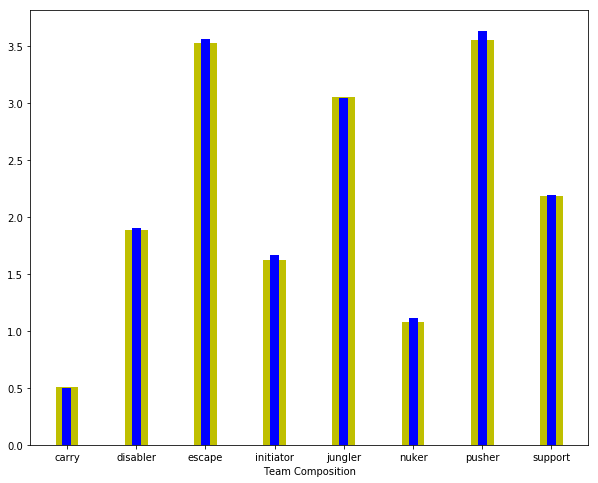

In [59]:
role_bits_df = role_bits_df.sort_values('role')
X = role_bits_df.index.tolist()
width = 0.33
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.bar(X,Y1,width,color='y',label='-Ymin')
ax.bar(X,Y2,width - 0.2,color='b',label='Ymax')
ax.set_xlabel('Team Composition')
plt.show()

In [60]:
Y1 = np.round(Y1)
Y1

array([1., 1., 2., 2., 4., 2., 4., 3.])

In [61]:
Y2 = np.round(Y2)
Y2

array([0., 1., 2., 2., 4., 2., 4., 3.])

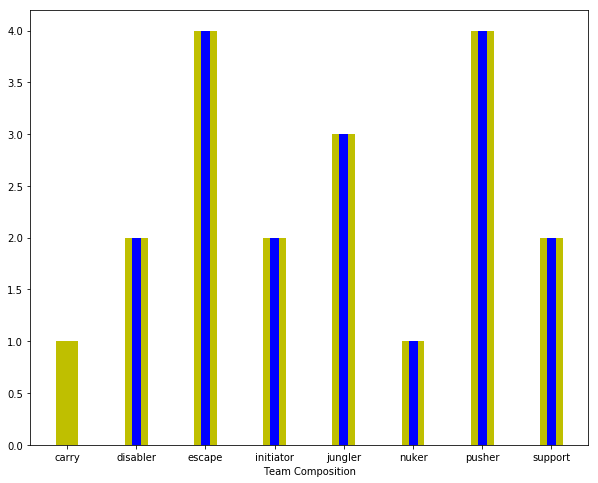

In [62]:
role_bits_df = role_bits_df.sort_values('role')
X = role_bits_df.index.tolist()
width = 0.33
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.bar(X,Y1,width,color='y',label='-Ymin')
ax.bar(X,Y2,width - 0.2,color='b',label='Ymax')
ax.set_xlabel('Team Composition')
plt.show()

### 6.2.6 Best Team compositions

In [63]:
winning_comp = [str(x) for x in winning_composition]
winning_comp = sorted(Counter(winning_comp).items())
winning_comp.sort(key = lambda x: x[1], reverse=True)
winning_comp_set = set(winning_comp[:10])

Y1 = [np.multiply(np.array(list(x[0][1:-1].replace(" ", "")), dtype=float), x[1]) for x in winning_comp[:10]]
total = [x[1] for x in winning_comp[:10]]
total = np.sum(total)
Y1 = np.sum(Y1, axis=0)
Y1 = np.divide(Y1, total)
Y1

array([0.13157895, 0.55263158, 1.52631579, 1.84210526, 3.47368421,
       2.28947368, 3.81578947, 3.28947368])

In [64]:
losing_comp = [str(x) for x in losing_composition]
losing_comp = sorted(Counter(losing_comp).items())
losing_comp.sort(key = lambda x: x[1], reverse=True)
losing_comp_set = set(losing_comp[:10])

Y2 = [np.multiply(np.array(list(x[0][1:-1].replace(" ", "")), dtype=float), x[1]) for x in losing_comp[:10]]
total = [x[1] for x in losing_comp[:10]]
total = np.sum(total)
Y2 = np.sum(Y2, axis=0)
Y2 = np.divide(Y2, total)
Y2

array([0.        , 0.56756757, 1.75675676, 1.91891892, 3.54054054,
       2.35135135, 4.24324324, 2.81081081])

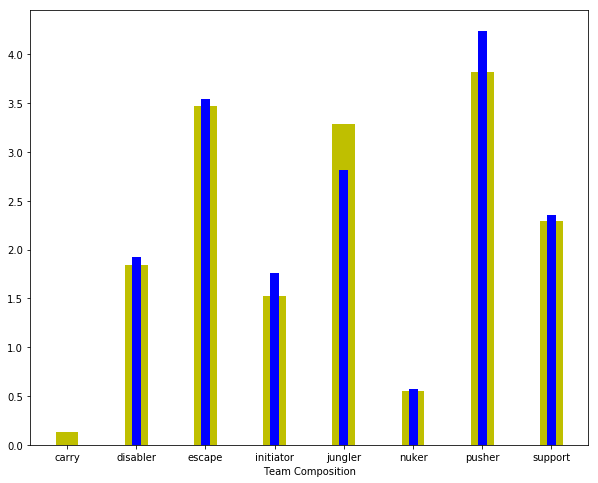

In [65]:
role_bits_df = role_bits_df.sort_values('role')
X = role_bits_df.index.tolist()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
width = 0.33
ax.bar(X,Y1,width,color='y',label='-Ymin')
ax.bar(X,Y2,width - 0.2,color='b',label='Ymax')
ax.set_xlabel('Team Composition')
plt.show()

Best team and worst team permutations

### 6.2.6 Most popular winning roles

In [66]:
from collections import Counter
win_team_list = [y for x in win_list for y in x]
win_team_list = sorted(Counter(win_team_list).items())
win_team_list.sort(key=lambda x: x[1], reverse=True)
win_set = set([x[0] for x in win_team_list])

In [67]:
len(win_set)

58

### 6.2.7 Most popular losing roles

In [68]:
from collections import Counter
lose_team_list = [y for x in lose_list for y in x]
lose_team_list = sorted(Counter(lose_team_list).items())
lose_team_list.sort(key=lambda x: x[1], reverse=True)
lose_set = set([x[0] for x in lose_team_list])

In [69]:
len(lose_set)

58

### 6.2.8 Comparing sets

In [70]:
win_set = [x[0] for x in win_team_list]
win_set = set(win_set[:8])

lose_set = [x[0] for x in lose_team_list]
lose_set = set(lose_set[:8])

In [71]:
win_diff = win_set.difference(lose_set)
win_diff = list(win_diff)
for score in win_diff:    
    bin_score = list(bin(score)[2:].zfill(8))
    print(bin_score)

['0', '1', '0', '1', '0', '0', '0', '1']


In [72]:
lose_diff = lose_set.difference(win_set)
lose_diff = list(lose_diff)
for score in lose_diff:
    bin_score = list(bin(score)[2:].zfill(8))
    print(bin_score)

['0', '0', '1', '0', '1', '1', '1', '1']


## 6.2 Hero Win rates

In [73]:
win_ratio_list = training_df['radiant_hero_win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x], dtype=float)
win_ratio_list.mean()

49.99244256109482

In [74]:
lose_ratio_list = training_df['dire_hero_win_ratio'].tolist()
lose_ratio_list = np.array([y for x in lose_ratio_list for y in x], dtype=float)
lose_ratio_list.mean()

50.00029983382209

## 6.3 Player win rate

In [75]:
win_ratio_list = training_df['radiant_win_ratio'].tolist()
win_ratio_list = np.array([y for x in win_ratio_list for y in x], dtype=float)
win_ratio_list.mean()

50.15287750391007

In [76]:
lose_ratio_list = training_df['dire_win_ratio'].tolist()
lose_ratio_list = np.array([y for x in lose_ratio_list for y in x[:2]], dtype=float)
lose_ratio_list.mean()

50.62559947189638

## 6.4 Worst player per team

In [77]:
win_df = player_df[player_df['win_lost'] == True]
player_win_ratio = win_df.groupby('match_id').agg({'win_ratio': lambda x: min(list(x))})
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

42.73426839252336

In [78]:
lose_df = player_df[player_df['win_lost'] == False]
player_win_ratio = lose_df.groupby('match_id').agg({'win_ratio': lambda x: min(list(x))})
player_win_ratio.head()
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

42.933096488105356

## 6.5 Best player per team

In [79]:
win_df = player_df[player_df['win_lost'] == True]
player_win_ratio = win_df.groupby('match_id').agg({'win_ratio': lambda x: max(list(x))})
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

58.36862240484282

In [80]:
lose_df = player_df[player_df['win_lost'] == False]
player_win_ratio = lose_df.groupby('match_id').agg({'win_ratio': lambda x: max(list(x))})
player_win_ratio.head()
player_list = player_win_ratio['win_ratio'].tolist()
player_list = np.array(player_list, dtype=float)
np.mean(player_list)

57.377559948598126

## 6.6 Player tendencies

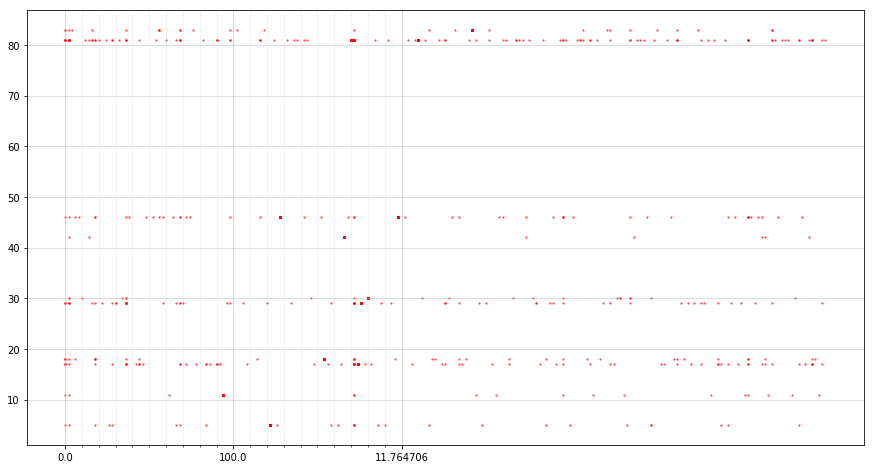

In [81]:
win_df = player_df[player_df['win_lost'] == True]
Y1 = win_df['score'].tolist()[:1500]
X1 = win_df['win_ratio'].tolist()[:1500]

lose_df = player_df[player_df['win_lost'] == False]
Y2 = lose_df['score'].tolist()[:1500]
X2 = lose_df['win_ratio'].tolist()[:1500]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 50)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

width = 2
ax.scatter(X1, Y1, width, color='r',label='Ymin', alpha = 0.5)

plt.show()

In [82]:
win_df['win_ratio'] = win_df['win_ratio'].astype(float)
win_df['win_ratio'].corr(win_df['score'])

/home/charmander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.019512844970388812

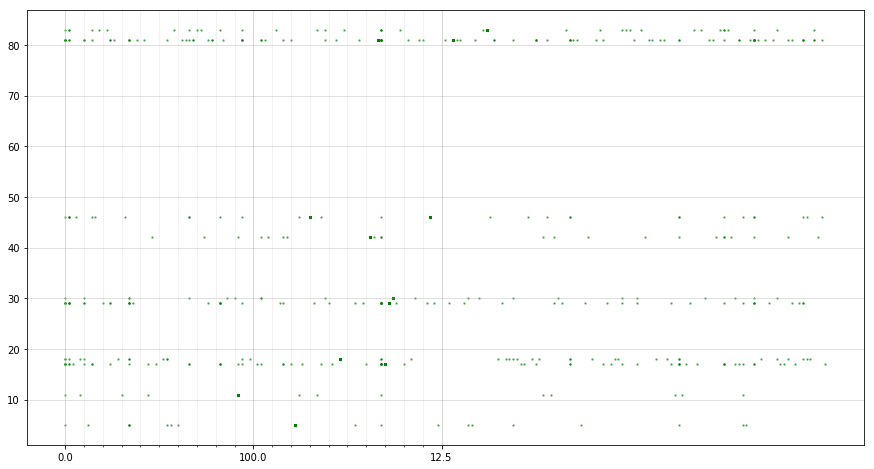

In [83]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 50)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

width = 2
ax.scatter(X2, Y2, width, color='g',label='Ymin', alpha = 0.5)

plt.show()

In [84]:
lose_df['win_ratio'] = lose_df['win_ratio'].astype(float)
lose_df['win_ratio'].corr(lose_df['score'])

/home/charmander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.018627549562693486

# 8. Predicting Winning Team

In [85]:
Y = training_df['radiant_win'].values.tolist()
X = training_df[['radiant_win_ratio', 'radiant_hero_win_ratio', 'radiant_score', 
                'dire_win_ratio', 'dire_hero_win_ratio', 'dire_score']].values.tolist()
for i in range(len(X)):
    X[i] = X[i][0] + X[i][1] + X[i][2] + X[i][3] + X[i][4] + X[i][5]

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42) 
clf = LogisticRegression(C=1e5)
clf.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
y_predicted = clf.predict(x_test)
accuracy = np.sum(y_predicted == y_test) * 100.0 / len(y_test)
(precision, recall, f1, _) = precision_recall_fscore_support(y_test, y_predicted)

In [89]:
result = {
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'accuracy': accuracy
}
pd.DataFrame(result)

,accuracy,f1,precision,recall
0,55.121951,0.486034,0.505814,0.467742
1,55.121951,0.601732,0.584034,0.620536


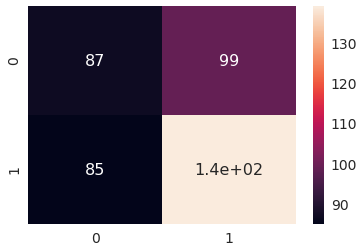

In [90]:
import seaborn as sn

cm = confusion_matrix(y_test, y_predicted)
df_cm = pd.DataFrame(cm, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size